In [43]:
import os
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from tensorflow.keras.losses import CategoricalCrossentropy # type: ignore
from tensorflow.keras.optimizers import Adam, RMSprop, Adamax # type: ignore
from tensorflow.keras.models import Sequential,Model # type: ignore
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Flatten, Dense) # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

In [44]:
train_dir = "C:/Users/Aryan/Downloads/datasets/asl_alphabet/train"
val_dir = "C:/Users/Aryan/Downloads/datasets/asl_alphabet/val"
test_dir  = "C:/Users/Aryan/Downloads/datasets/asl_alphabet/test"

In [45]:
def generate_dataset(path):
    data = {'imgpath': [], 'labels': []}
    
    folders = os.listdir(path)
    
    for folder in folders:
        folderpath = os.path.join(path, folder)
        files = os.listdir(folderpath)
        
        for file in files:
            filepath = os.path.join(folderpath, file)
            
            data['imgpath'].append(filepath)
            data['labels'].append(folder)
    
    return pd.DataFrame(data)

def dataset_splitter(dataset, train_size = 0.9, shuffle = True, random_state = 0):
    train_df, val_df = train_test_split(dataset, train_size = train_size, shuffle = shuffle, random_state = random_state)

    train_df = train_df.reset_index(drop = True)
    val_df = val_df.reset_index(drop = True)
    
    return train_df, val_df


In [46]:
dataset_path = 'C:/Users/Aryan/Downloads/ASL/archive (2)/asl_alphabet_train/asl_alphabet_train'

dataset = generate_dataset(dataset_path)

dataset.head()

,imgpath,labels
0,C:/Users/Aryan/Downloads/ASL/archive (2)/asl_a...,A
1,C:/Users/Aryan/Downloads/ASL/archive (2)/asl_a...,A
2,C:/Users/Aryan/Downloads/ASL/archive (2)/asl_a...,A
3,C:/Users/Aryan/Downloads/ASL/archive (2)/asl_a...,A
4,C:/Users/Aryan/Downloads/ASL/archive (2)/asl_a...,A


In [47]:
train_df, val_df= dataset_splitter(dataset)

print(f'\nTraining Dataframe of shape {train_df.shape}: \n{train_df.head()}')
print(f'\nValidation Dataframe of shape {val_df.shape}: \n{val_df.head()}')


Training Dataframe of shape (75600, 2): 
                                             imgpath   labels
0  C:/Users/Aryan/Downloads/ASL/archive (2)/asl_a...        H
1  C:/Users/Aryan/Downloads/ASL/archive (2)/asl_a...  nothing
2  C:/Users/Aryan/Downloads/ASL/archive (2)/asl_a...        Q
3  C:/Users/Aryan/Downloads/ASL/archive (2)/asl_a...        T
4  C:/Users/Aryan/Downloads/ASL/archive (2)/asl_a...        V

Validation Dataframe of shape (8400, 2): 
                                             imgpath labels
0  C:/Users/Aryan/Downloads/ASL/archive (2)/asl_a...      M
1  C:/Users/Aryan/Downloads/ASL/archive (2)/asl_a...      X
2  C:/Users/Aryan/Downloads/ASL/archive (2)/asl_a...      M
3  C:/Users/Aryan/Downloads/ASL/archive (2)/asl_a...      O
4  C:/Users/Aryan/Downloads/ASL/archive (2)/asl_a...      N


In [48]:
BATCH_SIZE = 128
IMG_SIZE = (64, 64)

train_generator = ImageDataGenerator(1./255, 
                                     rotation_range = 10, 
                                     height_shift_range = 0.1, 
                                     width_shift_range = 0.1)

val_generator = ImageDataGenerator(1./255)

train_images = train_generator.flow_from_dataframe(train_df, x_col = 'imgpath', y_col = 'labels', 
                                                   color_mode = 'grayscale', class_mode = 'categorical',
                                                   batch_size = BATCH_SIZE, target_size = IMG_SIZE, 
                                                   shuffle = True, seed = 0)

val_images = val_generator.flow_from_dataframe(val_df, x_col = 'imgpath', y_col = 'labels', 
                                               color_mode = 'grayscale', class_mode = 'categorical', 
                                               batch_size = BATCH_SIZE, target_size = IMG_SIZE)

Found 75600 validated image filenames belonging to 28 classes.
Found 8400 validated image filenames belonging to 28 classes.


In [49]:
labels = list(train_images.class_indices.keys())
print(labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'nothing', 'space']


In [66]:
output_shape = len(set(train_images.labels))

model = Sequential([
    Input(shape = IMG_SIZE + (1,), name = 'input_layer'),
    
    Conv2D(16, (3, 3), activation = 'relu'),
    MaxPooling2D(pool_size = (3, 3)),
    
    Conv2D(64, (3, 3), activation = 'relu'),
    MaxPooling2D(pool_size = (3, 3)),
    
    GlobalAveragePooling2D(),
    BatchNormalization(),
    
    Dense(512, activation = 'relu'),
    Dropout(0.3),
    
    Dense(output_shape, activation = 'softmax', name = 'output_layer')
])

model.compile(optimizer = Adamax(learning_rate = 0.001), 
              loss = CategoricalCrossentropy(), 
              metrics = ['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 20, 20, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 18, 18, 64)     │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 28)             │        14,364 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,340 (223.98 KB)

 Trainable params: 57,212 (223.48 KB)

 Non-trainable params: 128 (512.00 B)

In [67]:
history = model.fit(train_images, validation_data = val_images, epochs = 20)

Epoch 1/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 85s 141ms/step - accuracy: 0.2868 - loss: 2.5078 - val_accuracy: 0.5094 - val_loss: 1.6140
Epoch 2/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 84s 141ms/step - accuracy: 0.6551 - loss: 1.1087 - val_accuracy: 0.5414 - val_loss: 1.5798
Epoch 3/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 82s 138ms/step - accuracy: 0.7637 - loss: 0.7435 - val_accuracy: 0.7450 - val_loss: 0.7529
Epoch 4/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 82s 137ms/step - accuracy: 0.8173 - loss: 0.5661 - val_accuracy: 0.8265 - val_loss: 0.5182
Epoch 5/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 84s 140ms/step - accuracy: 0.8506 - loss: 0.4599 - val_accuracy: 0.6705 - val_loss: 1.2573
Epoch 6/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 81s 136ms/step - accuracy: 0.8711 - loss: 0.3920 - val_accuracy: 0.8469 - val_loss: 0.4510
Epoch 7/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 84s 140ms/step - accuracy: 0.8865 - loss: 0.3462 - val_accuracy: 0.8371 - val_loss: 0.5049
Epoch 8/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 83s 140ms/step - accuracy: 0.9006 - loss: 0

In [86]:
results = model.evaluate(val_images, verbose = 0)

print("Validation Loss: {:.5f}".format(results[0]))
print("Validation Accuracy: {:.2f}%".format(results[1] * 100))

Validation Loss: 0.17046
Validation Accuracy: 94.15%


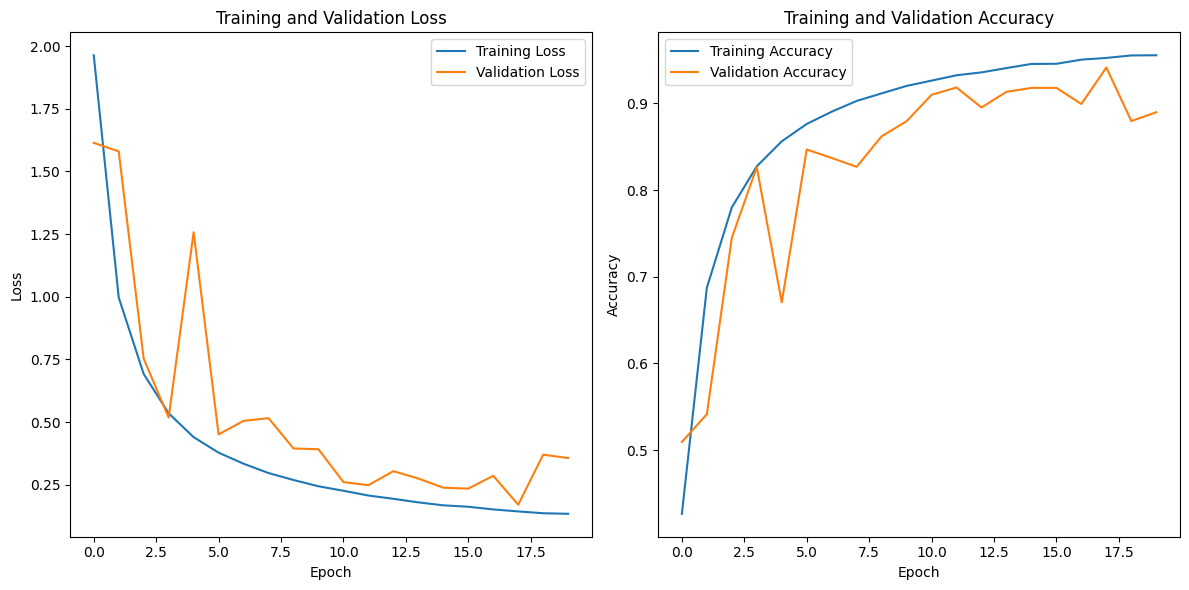

In [69]:
plt.figure(figsize = (12, 6))

# loss plot

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# accuracy plot

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# display the plot

plt.tight_layout()
plt.show()

In [ ]:
imgs_dir = 'C:/Users/Aryan/Downloads/ASL/archive (2)/asl_alphabet_test/asl_alphabet_test'
imgs = os.listdir(imgs_dir)

class_mapping = train_images.class_indices

def get_class_label(predictions, class_mapping):
    labels_mapping = {v: k for k, v in class_mapping.items()}
    predicted_labels = [labels_mapping[pred] for pred in predictions]
    return predicted_labels

def predict_image_class(model, img_path, class_mapping):
    img = cv2.imread(os.path.join(imgs_dir, img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = np.expand_dims(cv2.resize(img, (64, 64)), axis = 0)
    predictions = np.argmax(model.predict(img, verbose = 0), axis = 1)
    predicted_labels = get_class_label(predictions, class_mapping)
    return predicted_labels

true_labels = []
predicted_label = []

# Collect predictions for all images

for img in imgs:
    predicted_labels = predict_image_class(model, img, class_mapping)
    print(f'Predicted Labels {img} -----> {predicted_labels}')
    predicted_label.extend(predicted_labels)
    true_label = img.split('_')[0]
    true_labels.append(true_label)

    

In [75]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(true_labels, predicted_label, labels=list(class_mapping.keys()))
cr = classification_report(true_labels, predicted_label, target_names=list(class_mapping.keys()))

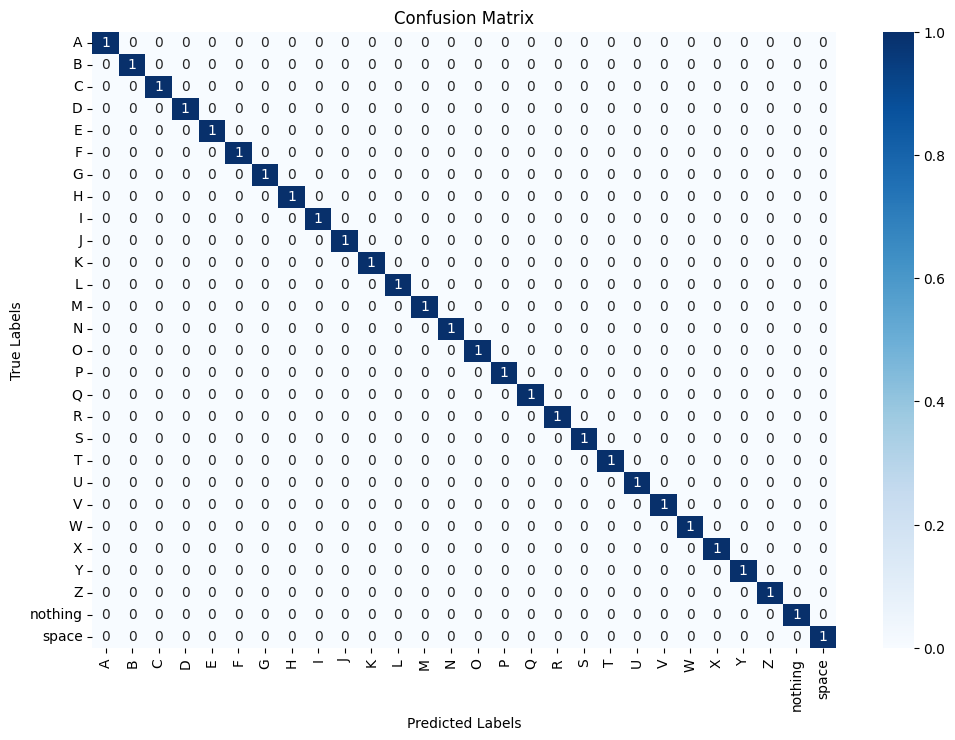

Classification Report
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         1
           B       1.00      1.00      1.00         1
           C       1.00      1.00      1.00         1
           D       1.00      1.00      1.00         1
           E       1.00      1.00      1.00         1
           F       1.00      1.00      1.00         1
           G       1.00      1.00      1.00         1
           H       1.00      1.00      1.00         1
           I       1.00      1.00      1.00         1
           J       1.00      1.00      1.00         1
           K       1.00      1.00      1.00         1
           L       1.00      1.00      1.00         1
           M       1.00      1.00      1.00         1
           N       1.00      1.00      1.00         1
           O       1.00      1.00      1.00         1
           P       1.00      1.00      1.00         1
           Q       1.00      1.00      1.00         1
     

In [77]:
import seaborn as sns

# Display the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_mapping.keys(), yticklabels=class_mapping.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print('Classification Report')
print(cr)